# Tweet categorization
### To Build, Train and Deploy Machine Learning model which will extract data from twitter and will classify tweets according to different types of emotions/ topics.

## Final notebook 1: Preprocessing and clustering 

### 1) Extracting tweets
Twint uses the classic Twitter search and can thus retrieve all the tweets from an account. It can even retrieve only those containing the keyword of choice, or those posted between such and such a date, or from such and such a place, or only the retweets. It is also possible to retrieve all tweets from all Twitter accounts that mention the keyword of your choice. It automatically saves the data scrapped into a csv file named tweetsfromvodafonin2. Using this we scrapped all tweets of keyword vodafonein. About 20k tweets were scrapped using the following code

In [ ]:
pip install twint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 263 kB 8.5 MB/s 
     |████████████████████████████████| 382 kB 40.2 MB/s 
     |████████████████████████████████| 288 kB 44.1 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 139 kB 58.4 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Created wheel for twint: filename=twint-2.1.20-py3-none-any.whl size=33929 sha256=8068132ee613e2cc3717693a1b9970780344ad20e07daf11738fa015bfd30dc0
  Stored in directory: /root/.cache/pip/wheels/44/fc/77/99887a36b5c265a87516158858697d1a0b8f32c4d4dbddbb24
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=fc7c160c92658ef5708541f8191eda05b559eb689a9ad0be9ab65de46c85b0b1
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9

In [ ]:
import twint
# Configure
c = twint.Config()
c.Search = "vodafoneIN"
c.limit=1000
c.Format ="Tweet id: {id}|Date:{date}|Time:{time}|Tweet:{tweet}"
c.Store_csv = True
c.Output = "tweetsfromvodafonin2"
# Run
twint.run.Search(c)

RuntimeError: ignored

Importing the libraries required

In [ ]:
import nltk
import numpy as np
import re
import pandas as pd 
import pylab as pl
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn import metrics




%matplotlib inline







### 2) Data Cleaning and preprocessing
The csv file of 20k tweets is imported

In [ ]:
df  = pd.read_csv("tweetsfromvodafonin2.csv",encoding = 'ISO-8859-1')
print(len(df))

21047


In [ ]:
unique_text = df.tweet.unique()
print(len(unique_text))

21047


In [ ]:
df.head(2)


,username,date,tweet,mentions
0,shivaji_takey,10-06-2020,Please check what happens to this no 940417705...,['vodafonein']
1,sarasberiwala,10-06-2020,Network fluctuations and 4G Speed is pathetic....,['vodafonein']


# Cleaning Text:
Removing numbers, symbols like @#, making the string in lower case

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt


In [ ]:
df['Clean_text'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")

In [ ]:
df['Clean_text'] = df['Clean_text'].str.replace("[^a-zA-Z#]", " ")

In [ ]:
df["Clean_text"]= df["Clean_text"].str.lower() 

In [ ]:

df['Clean_text'] = df['Clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

,username,date,tweet,mentions,Clean_text
0,shivaji_takey,10-06-2020,Please check what happens to this no 940417705...,['vodafonein'],please check what happens this woking since lo...
1,sarasberiwala,10-06-2020,Network fluctuations and 4G Speed is pathetic....,['vodafonein'],network fluctuations speed pathetic need alter...
2,chitreamod,10-06-2020,This has been going on since 3rd... this absol...,['vodafonein'],this been going since this absolutely unprofes...
3,sanjan_suman,10-06-2020,@VodafoneIN I have done my recharge of 555 on...,['vodafonein'],have done recharge haven perday with unlimited...
4,t_nihsit,10-06-2020,But when???Still I am not received any call fr...,['vodafonein'],when still received call from customer care ve...


In [ ]:
df.loc[:,('Clean_text')]

0        please check what happens this woking since lo...
1        network fluctuations speed pathetic need alter...
2        this been going since this absolutely unprofes...
3        have done recharge haven perday with unlimited...
4        when still received call from customer care ve...
                               ...                        
21042                          sent contact still response
21043    dear have facing network problem days solve pr...
21044    rubbish made many time didn resolved network p...
21045    caller tunes sound horrible song heard from sa...
21046    what nonsense guys saying getting possible cal...
Name: Clean_text, Length: 21047, dtype: object

Droping the duplicates

In [ ]:
df.drop_duplicates(subset=['Clean_text'], keep = 'first',inplace= True)


In [ ]:
df.reset_index(drop=True,inplace=True)

Droping the the tweet with length 0

In [ ]:

df['Clean_text_length'] = df['Clean_text'].apply(len)
df.head()

,username,date,tweet,mentions,Clean_text,Clean_text_length
0,shivaji_takey,10-06-2020,Please check what happens to this no 940417705...,['vodafonein'],please check what happens this woking since lo...,64
1,sarasberiwala,10-06-2020,Network fluctuations and 4G Speed is pathetic....,['vodafonein'],network fluctuations speed pathetic need alter...,66
2,chitreamod,10-06-2020,This has been going on since 3rd... this absol...,['vodafonein'],this been going since this absolutely unprofes...,52
3,sanjan_suman,10-06-2020,@VodafoneIN I have done my recharge of 555 on...,['vodafonein'],have done recharge haven perday with unlimited...,142
4,t_nihsit,10-06-2020,But when???Still I am not received any call fr...,['vodafonein'],when still received call from customer care ve...,62


In [ ]:
df[df['Clean_text_length']==0]['Clean_text'] ## Looks like these are tweets with different languages or just hastags.
# We can simply drop these tweets
list = df[df['Clean_text_length']==0]['Clean_text'].index
list

Int64Index([20], dtype='int64')

In [ ]:
df['Clean_text'].head()

0    please check what happens this woking since lo...
1    network fluctuations speed pathetic need alter...
2    this been going since this absolutely unprofes...
3    have done recharge haven perday with unlimited...
4    when still received call from customer care ve...
Name: Clean_text, dtype: object

# TF-IDF
(term frequency-inverse document frequency)
Is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# Considering 3 grams and mimnimum frq as 0
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001, max_df=0.7)
tf_idf_vect.fit(df['Clean_text'])
desc_matrix = tf_idf_vect.transform(df["Clean_text"])
desc_matrix

<19502x6096 sparse matrix of type '<class 'numpy.int64'>'
	with 173130 stored elements in Compressed Sparse Row format>

# KMeans clustering
The algorithm works as follows:

1.   First we initialize k points, called means, randomly.
2.   We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
3.  We repeat the process for a given number of iterations and at the end, we have our clusters.


*Made 8 cluster for the different problems of the custoers according to the tweets*


In [ ]:
from sklearn.cluster import KMeans
num_clusters = 8
km = KMeans(n_clusters=num_clusters)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

In [ ]:

from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

In [ ]:
tweets = {'Tweet': df["Clean_text"].tolist(), 'Cluster': clusters}
frame = pd.DataFrame(tweets, index = [clusters])


In [ ]:
frame.to_csv('clustered_tweets.csv')

In [ ]:
frame  = pd.read_csv("clustered_tweets.csv")

In [ ]:
frame.head()

,Unnamed: 0,Tweet,Cluster
0,0,please check what happens this woking since lo...,0
1,4,network fluctuations speed pathetic need alter...,4
2,0,this been going since this absolutely unprofes...,0
3,0,have done recharge haven perday with unlimited...,0
4,6,when still received call from customer care ve...,6


# WordCloud
Shown wordcloud for each clustter and printed the tweets for the clustter

In [ ]:
def wordcloud(cluster):
  # combining the image with the dataset
  Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

  # We use the ImageColorGenerator library from Wordcloud 
  # Here we take the color of the image and impose it over our wordcloud
  image_colors = ImageColorGenerator(Mask)

  # Now we use the WordCloud function from the wordcloud library 
  wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(cluster)

  # Size of the image generated 
  plt.figure(figsize=(10,20))

  # Here we recolor the words from the dataset to the image's color
  # recolor just recolors the default colors to the image's blue color
  # interpolation is used to smooth the image generated 
  plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

  plt.axis('off')
  plt.show()

In [ ]:
frame['Cluster'].value_counts()

0    8608
5    2299
4    2248
2    2033
3    1536
6    1514
7     996
1     267
Name: Cluster, dtype: int64

In [ ]:
cluster_0=frame[frame['Cluster'] == 0]
cluster_0

,Unnamed: 0,Tweet,Cluster
0,0,please check what happens this woking since lo...,0
2,0,this been going since this absolutely unprofes...,0
3,0,have done recharge haven perday with unlimited...,0
6,0,thanks have visited website called your execut...,0
12,0,internet working assist asap,0
...,...,...,...
19494,0,please check have sent numbers please revert b...,0
19495,0,sorry kidding last hour your contact instead t...,0
19496,0,sent contact still response,0
19499,0,caller tunes sound horrible song heard from sa...,0


In [ ]:
cluster_0_words = ' '.join(text for text in cluster_0['Tweet'])

Cluster 0: Tells about the problems related to services

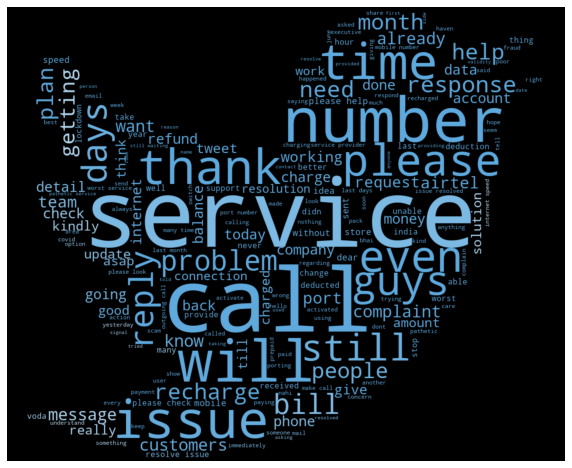

In [ ]:
wordcloud(cluster_0_words)

In [ ]:
cluster_1=frame[frame['Cluster'] == 1]

In [ ]:
cluster_1

,Unnamed: 0,Tweet,Cluster
5127,1,just inform about activation your sales repres...,1
7831,1,dear customer this inform that rental amount b...,1
10813,1,dear customer this inform that rental amount b...,1
10941,1,have below where have availed asked such servi...,1
11184,1,vodafone number june message comes from vodafo...,1
...,...,...,...
17558,1,dear customer this inform that rental amount b...,1
17566,1,this suddenly dear customer this inform that r...,1
17570,1,dear customer this inform that rental amount b...,1
17575,1,dear vodafone when international flights halt ...,1


In [ ]:
cluster_1_words = ' '.join(text for text in cluster_1['Tweet'])


cluster 1: tells about the problems about renatal amount

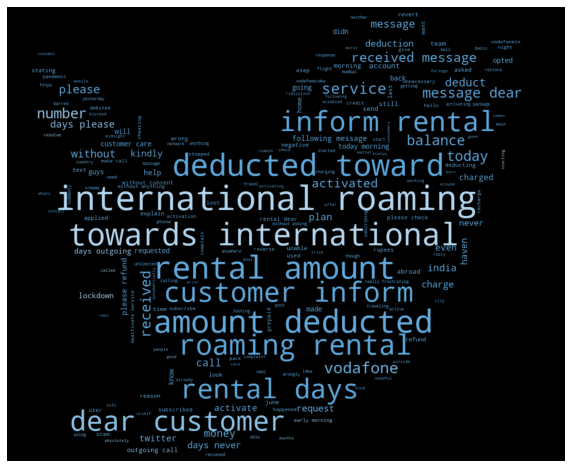

In [ ]:
wordcloud(cluster_1_words)

In [ ]:
cluster_2=frame[frame['Cluster'] == 2]

In [ ]:
frame[frame['Cluster'] == 2]

,Unnamed: 0,Tweet,Cluster
17,2,double data speed #same vodafone twitter vpgpk...,2
27,2,have already used link done please reference p...,2
32,2,super fast network thank twitter kjuwrubv,2
34,2,provide speed sufficient network stop selling ...,2
53,2,this happening since morning happens every wee...,2
...,...,...,...
19433,2,india best network what brilliant speed needs ...,2
19449,2,they stopped replying mail facebook post twitt...,2
19457,2,this plan choose bill with plan twitter acmw,2
19472,2,experience with number deduction balance autom...,2


Cluster 2:- Tells about the problem related to speed

In [ ]:
cluster_2_words = ' '.join(text for text in cluster_2['Tweet'])

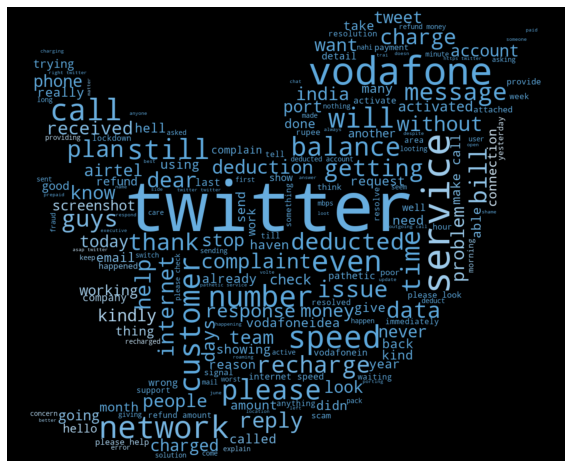

In [ ]:
wordcloud(cluster_2_words)

In [ ]:
cluster_3=frame[frame['Cluster'] == 3]

In [ ]:
frame[frame['Cluster'] == 3]

,Unnamed: 0,Tweet,Cluster
302,3,could please help disaster #airtel number pinc...,3
334,3,https google thehindubusinessline info tech vo...,3
458,3,last month charged international roaming waved...,3
469,3,proper response private message your solution ...,3
583,3,been charged international roaming,3
...,...,...,...
17612,3,didn understand when bangalore become internat...,3
17649,3,never ever knew guys would international roami...,3
18474,3,again started cheating your customer deducted ...,3
19437,3,getting satisfied reply from saying that this ...,3


In [ ]:
cluster_3_words = ' '.join(text for text in cluster_3['Tweet'])

Cluster 3:-Tells about the problem related to internationa roaming

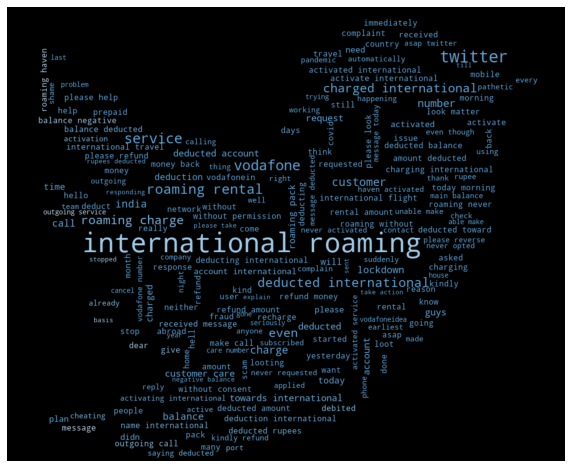

In [ ]:
wordcloud(cluster_3_words)

In [ ]:
cluster_4=frame[frame['Cluster'] == 4]

In [ ]:
frame[frame['Cluster'] == 4]

,Unnamed: 0,Tweet,Cluster
1,4,network fluctuations speed pathetic need alter...,4
5,4,mere area vodafone network raha bhitoli luckow...,4
9,4,market area bilkul network nahi raha call aata...,4
22,4,when assure your customers that service will g...,4
23,4,gonna port into network hope works well,4
...,...,...,...
19484,4,area soon there power failure mobile network p...,4
19486,4,please move vodafone waste network seriously o...,4
19490,4,very very poor internet speed network govindpu...,4
19497,4,dear have facing network problem days solve pr...,4


In [ ]:
cluster_4_words = ' '.join(text for text in cluster_4['Tweet'])

Cluster 4: Tells about the problem related to network

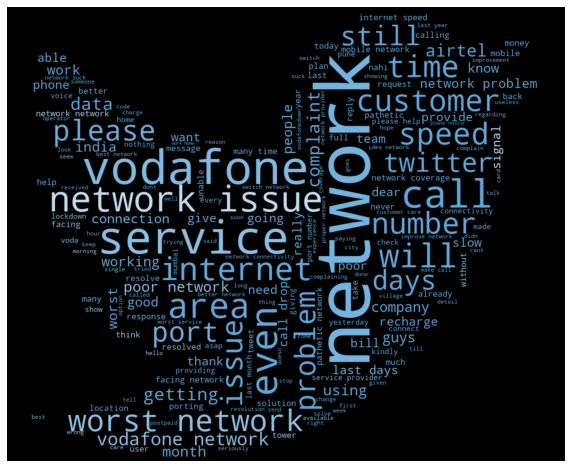

In [ ]:
wordcloud(cluster_4_words)

In [ ]:
cluster_5=frame[frame['Cluster'] == 5]

In [ ]:
frame[frame['Cluster'] == 5].head()

,Unnamed: 0,Tweet,Cluster
8,5,dear vodafone have already responded your repl...,5
11,5,vodafone netwrk worst ever using from many yea...,5
19,5,please help with exact process changing owners...,5
24,5,someone misused documents card sent mail vodaf...,5
35,5,vodafone provide recharge offers along with ho...,5


In [ ]:
cluster_5_words = ' '.join(text for text in cluster_5['Tweet'])

cluster 5: Tells about the problem related to reply frm the company

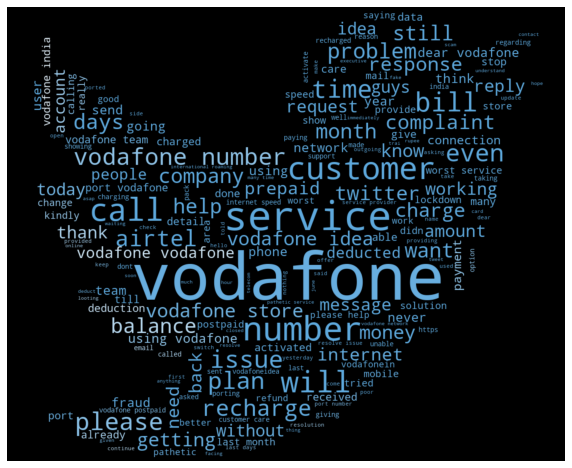

In [ ]:
wordcloud(cluster_5_words)

In [ ]:
cluster_6=frame[frame['Cluster'] == 6]

In [ ]:
frame[frame['Cluster'] == 6]

,Unnamed: 0,Tweet,Cluster
4,6,when still received call from customer care ve...,6
7,6,today vodafone deactivated without information...,6
16,6,worst customer care charged internet postpaid ...,6
39,6,request call back committed same iroam free pa...,6
56,6,sense complaining such worst network disrespec...,6
...,...,...,...
19423,6,when your engineer didn came called again just...,6
19443,6,called been http hours this work first illegal...,6
19466,6,idea customer changed they really sucks blood ...,6
19478,6,since last month facing issue regarding incomi...,6


Cluster 6 :Tells about the problem related to customer care

In [ ]:
cluster_6_words = ' '.join(text for text in cluster_6['Tweet'])

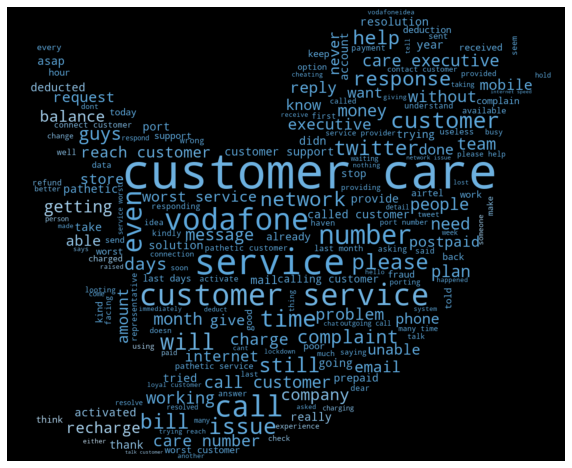

In [ ]:
wordcloud(cluster_6_words)

In [ ]:
cluster_7=frame[frame['Cluster'] == 7]

Cluster 7: other problems like https twitter status

In [ ]:
frame[frame['Cluster'] == 7]

,Unnamed: 0,Tweet,Cluster
10,7,hell previous plan deactivated hell active pla...,7
46,7,bhai company wale mera sale jese salo mera blo...,7
88,7,response from your know people doing like this...,7
122,7,knowns when call will come #waiting #pathetic ...,7
161,7,shame https twitter status,7
...,...,...,...
19435,7,https twitter mushtabaarshad status,7
19452,7,https twitter aghorababa status,7
19455,7,village belongs still face ntwrk prblm want be...,7
19463,7,abey tumlog jhaago https twitter aghorababa st...,7


In [ ]:
cluster_7_words = ' '.join(text for text in cluster_7['Tweet'])

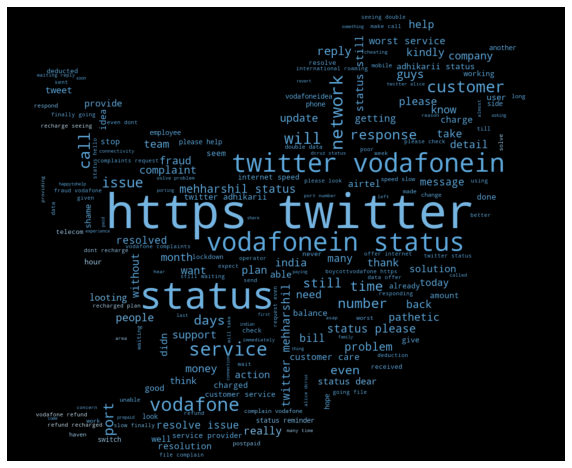

In [ ]:
wordcloud(cluster_7_words)